In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as stats
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

In [2]:
from astropy.io import fits

# # load data from APOGEE
# load data from fits file
ap_file = fits.open('allStar-l30e.2.fits')
ap_names = ap_file[1].columns.names
ap_dtype = ap_file[1].columns.formats
ap_data = ap_file[1].data

In [3]:
from astropy.table import Table, join

# create table for chemical abundances and radial velocity
names = np.array(['APOGEE_ID', 'GLON', 'GLAT', 'VHELIO_AVG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 
                  'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE','TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 
                  'FE_H', 'CO_FE', 'NI_FE', 'CU_FE', 'GE_FE', 'RB_FE'])
element_names = np.array(['C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE',
         'K_FE', 'CA_FE','TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'FE_H', 'CO_FE', 'NI_FE', 'CU_FE', 
        'GE_FE', 'RB_FE'])
dtype = ['float' for n in range(len(names))]
dtype[0] = 'string'
data = []
for name in names:
    data.append(ap_data.field(name))
ap_table = Table(data=data, names=names, dtype=dtype)

In [4]:
# add distance
dist_file = fits.open('apogee-BPGdistances_DR13_v2.0.fits')
dist_cols = dist_file[1].columns
dist_data = dist_file[1].data
dist_IDs = dist_data.field('APOGEE_ID')
dist_med = dist_data.field('d_med')
dist_95L = dist_data.field('d_95L')
dist_68L = dist_data.field('d_68L')
dist_68U = dist_data.field('d_68U')
dist_95U = dist_data.field('d_95U')
names = ['APOGEE_ID', 'd_95L', 'd_68L', 'd_med', 'd_68U', 'd_95U']
dtype = ['float' for n in range(len(names))]
dtype[0] = 'string'
dist_table = Table(data=[dist_IDs, dist_95L, dist_68L, dist_med, dist_68U, dist_95U], 
                   names=names, masked=True, dtype=dtype)
ap_table = join(ap_table, dist_table, keys='APOGEE_ID', join_type='left')
ap_table['d_95L'].mask = np.isnan(ap_table['d_95L'])
ap_table['d_68L'].mask = np.isnan(ap_table['d_68L'])
ap_table['d_med'].mask = np.isnan(ap_table['d_med'])
ap_table['d_68U'].mask = np.isnan(ap_table['d_68U'])
ap_table['d_95U'].mask = np.isnan(ap_table['d_95U'])

In [5]:
# add membership
known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
member_IDs = known_clusters[0]
member_names = known_clusters[1]
cluster_names = list(set(member_names))
k = 0
for name in cluster_names:
    index = np.where(member_names == name)[0]
    labels[index] = k
    k += 1
names = ['APOGEE_ID', 'cluster_name', 'label']
dtype=['string', 'string', 'int']
member_table = Table(data=[member_IDs, member_names, labels], names=names, dtype=dtype)
ap_table = join(ap_table, member_table, keys='APOGEE_ID', join_type='left')

In [6]:
# assign values to masked positions
ap_table['d_95L'].fill_value = -9999.
ap_table['d_68L'].fill_value = -9999.
ap_table['d_med'].fill_value = -9999.
ap_table['d_68U'].fill_value = -9999.
ap_table['d_95U'].fill_value = -9999.
ap_table['cluster_name'].fill_value = 'background'
ap_table['label'].fill_value = -1
ap_table = ap_table.filled()

In [7]:
# indexes of stars with full chemical abundances
index_chem = np.arange(len(ap_table))
for name in element_names:
    index_chem = np.intersect1d(index_chem, np.where(ap_table[name] > -9999.)[0])
# indexes of members 
index_member = np.where(ap_table['cluster_name'] != 'background')[0]
# indexes of members with full chemical abundances
index_m_c = np.intersect1d(index_member, index_chem)

In [8]:
def get_correlation(chem, elements):
    '''
    get correlations among chemical elements.
    
    :param chem:
        The matrix that contains chemical abundances with 
        the shape (num_stars, num_elements)
        
    :param elements:
        The array that contains the names of element abundances
        
    :returns:
    The correlation matrix
    '''
    n_elements = len(elements)
    # get the correlation matrix for all stars
    correlation = np.corrcoef(chem.T)
    # plot correlation matrix
    fig_corr = plt.figure(figsize=(10,8))
    plt.pcolor(correlation)
    plt.colorbar()
    plt.yticks(np.arange(0.5,n_elements + .5), elements)
    plt.xticks(np.arange(0.5,n_elements + .5), elements)
    plt.xticks(rotation=70)
    plt.xlim(0,n_elements)
    plt.ylim(0,n_elements)
    plt.show()
    return correlation

In [9]:
from sklearn.decomposition import PCA

def get_PCA(chem):
    '''
    get the transformed data after PCA.
    
    :param chem:
        The matrix that contains chemical abundances with 
        the shape (num_stars, num_elements)
        
    :returns:
    transform data
    '''
    # perform PCA
    n_components = len(chem[0])
    pca = PCA(n_components = n_components)
    chem_pca = pca.fit_transform(chem)
    # plot results from PCA
    ratio = np.around(pca.explained_variance_ratio_, decimals=3)
    # plot explained variance ratio
    ratio_increment = [sum(ratio[:n+1]) for n in range(n_components)]
    ratio_increment = np.around(ratio_increment, decimals=3)
    print ratio_increment
    f, ax = plt.subplots()
    x = range(1,n_components+1)
    ax.plot(x, ratio_increment)
    ax.set_xlabel('principal component')
    ax.set_ylabel('ratio')
    ax.set_xticks(x)
    ax.set_xlim(0.5, x[-1] + .5)
    ax.set_ylim(ratio_increment[0] * .95, 1)
    f.set_size_inches(8, 6)
    plt.show()
    return chem_pca

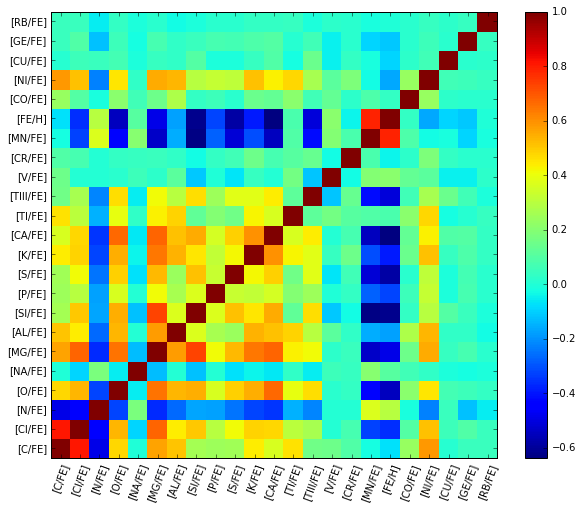

[ 0.216  0.364  0.483  0.577  0.652  0.726  0.782  0.829  0.868  0.901
  0.925  0.944  0.958  0.967  0.975  0.982  0.987  0.991  0.994  0.996
  0.998  1.     1.001]


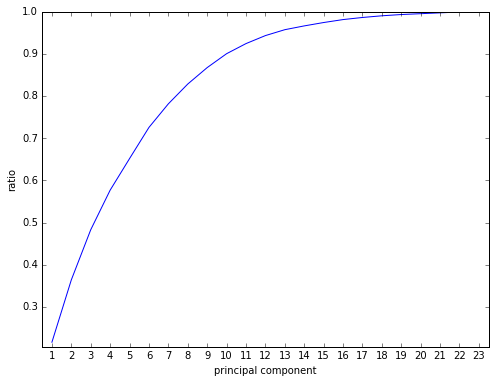

In [10]:
element_label_Fe = ['[' + name.replace('_', '/') + ']' for name in element_names]
chem_Fe = np.array([np.array(ap_table[element][index_chem], dtype=float) for element in element_names])
chem_Fe = chem_Fe.T
correlation_Fe = get_correlation(chem_Fe, element_label_Fe)
pca_Fe = get_PCA(chem_Fe)

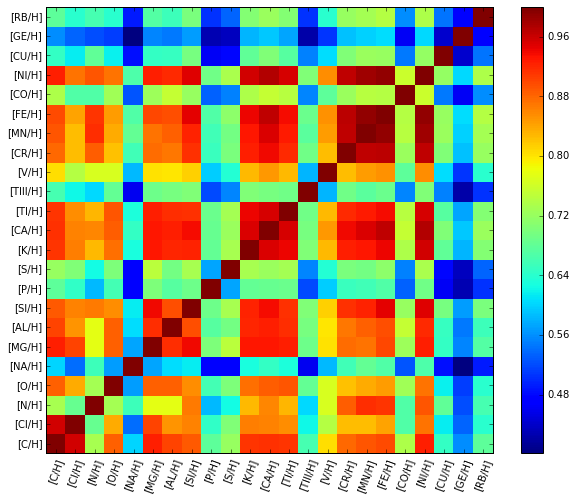

[ 0.718  0.772  0.816  0.847  0.875  0.901  0.921  0.938  0.953  0.965
  0.974  0.98   0.984  0.987  0.99   0.992  0.994  0.995  0.996  0.997
  0.998  0.998  0.998]


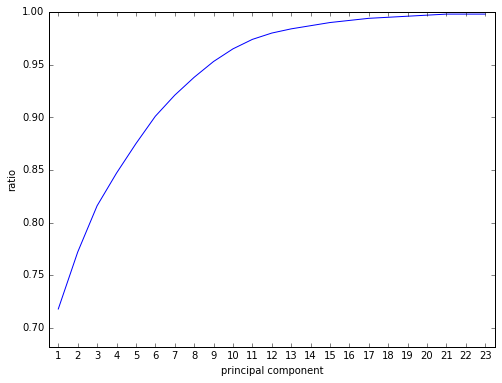

In [11]:
element_label_H = ['[' + name.replace('_', '/') + ']' for name in element_names]
element_label_H = [name.replace('/FE', '/H') for name in element_label_H]
chem_H = []
for element in element_names:
    if element != 'FE_H':
        chem_H.append((ap_table[element] + ap_table['FE_H'])[index_chem])
    else:
        chem_H.append((ap_table[element])[index_chem])
chem_H = np.array(chem_H).T
correlation_H = get_correlation(chem_H, element_label_H)
pca_H = get_PCA(chem_H)

M107 has 18 members


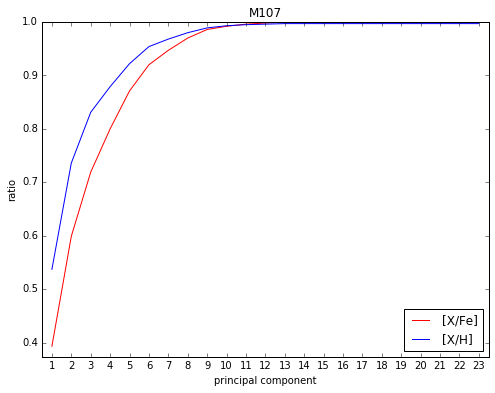

M13 has 119 members


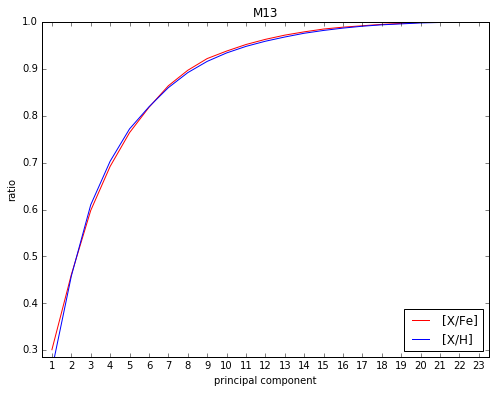

M15 has 20 members


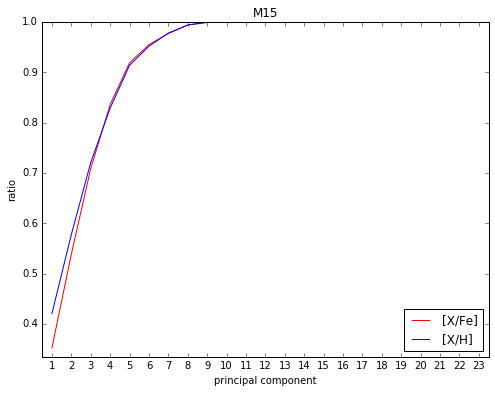

M2 has 61 members


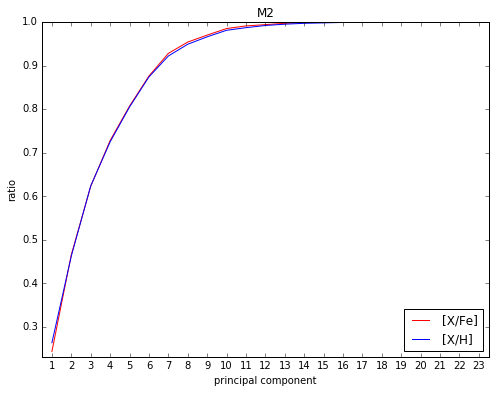

M3 has 226 members


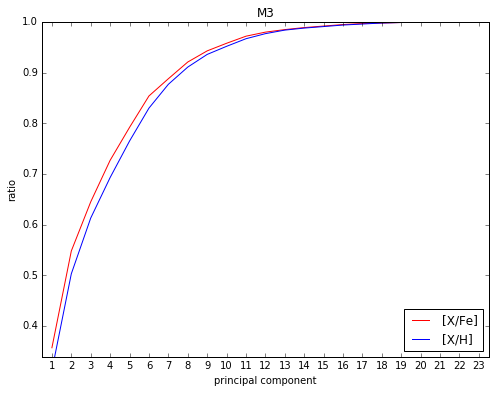

M5 has 142 members


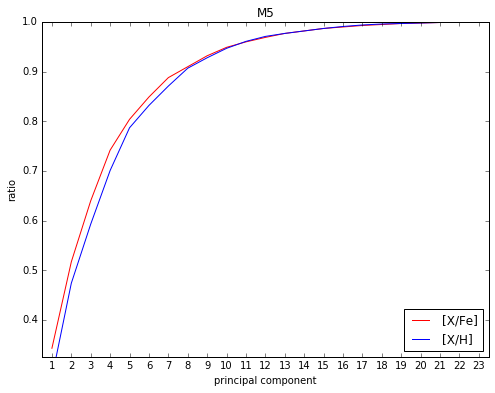

M53 has 25 members


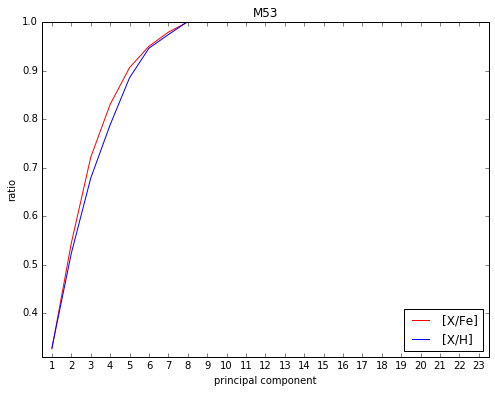

M67 has 24 members


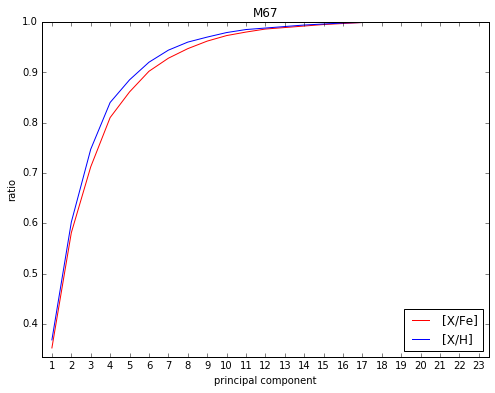

M71 has 28 members


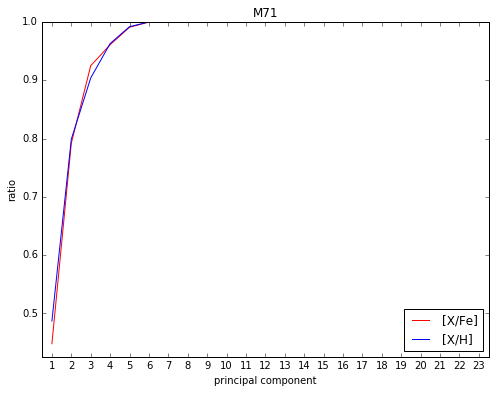

M92 has 54 members


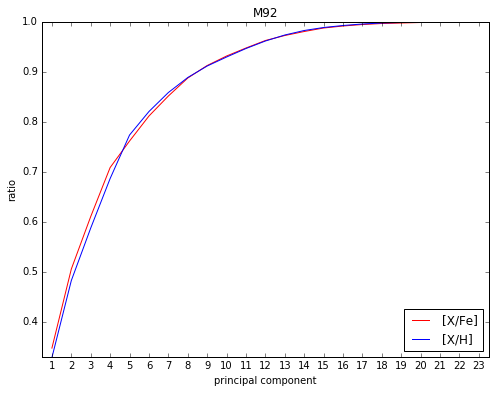

N5466 has 17 members


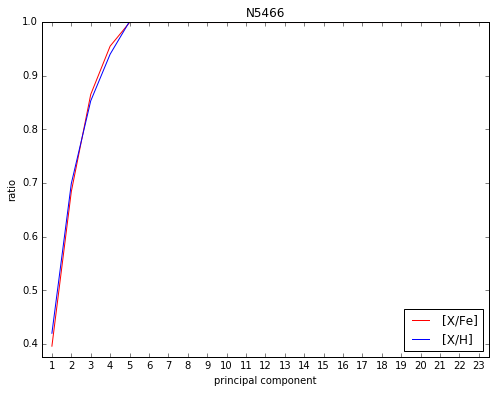

N6791 has 23 members


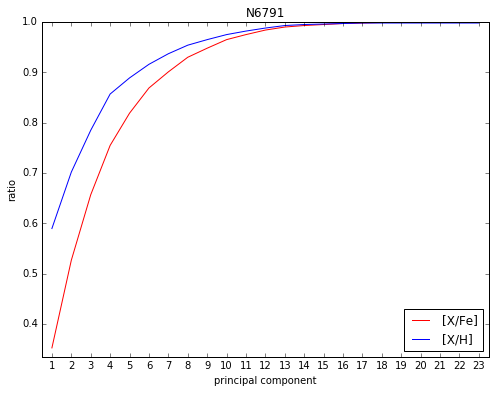

N6819 has 30 members


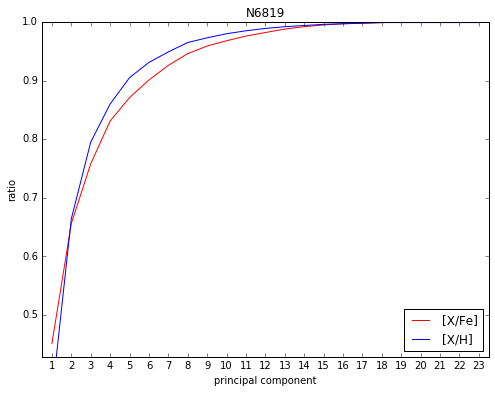

In [12]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values=-9999., strategy='mean', axis=0)
# get rid of clusters with fewer than 10 stars and Pleiades
member_table = ap_table[index_member].group_by('cluster_name')
index = [k for k in range(len(member_table.groups)-1) if len(member_table.groups[k]) > 10]
member_table = member_table.groups[index]
# iterate though clusters
for group in member_table.groups:
    print '%s has %i members'%(group['cluster_name'][0], len(group))
    # compose the matrix with chemical abundances
    chem_Fe = np.array([np.array(group[element], dtype=float) for element in element_names])
    chem_Fe = chem_Fe.T
    chem_Fe = imp.fit_transform(chem_Fe)
    idx_Fe = np.where(element_names == 'FE_H')[0][0]
    chem_H = chem_Fe.T
    chem_H = np.array([chem_H[k]+chem_H[idx_Fe] for k in range(len(element_names))])
    chem_H[idx_Fe] = chem_Fe.T[idx_Fe]
    chem_H = chem_H.T
    # perform PCA
    n_components = len(element_names)
    pca = PCA(n_components = n_components)
    chem_pca_Fe = pca.fit_transform(chem_Fe)
    ratio_Fe = np.around(pca.explained_variance_ratio_, decimals=3)
    chem_pca_H = pca.fit_transform(chem_H)
    ratio_H = np.around(pca.explained_variance_ratio_, decimals=3)
    ratio_increment_Fe = [sum(ratio_Fe[:n+1]) for n in range(n_components)]
    ratio_increment_Fe = np.around(ratio_increment_Fe, decimals=3)
    ratio_increment_H = [sum(ratio_H[:n+1]) for n in range(n_components)]
    ratio_increment_H = np.around(ratio_increment_H, decimals=3)
    # plot results from PCA
    f, ax = plt.subplots()
    x = range(1,n_components+1)
    ax.plot(x, ratio_increment_Fe, 'r', label='[X/Fe]')
    ax.plot(x, ratio_increment_H, 'b', label='[X/H]')
    ax.set_xlabel('principal component')
    ax.set_ylabel('ratio')
    ax.set_xticks(x)
    ax.set_xlim(0.5, x[-1] + .5)
    ax.set_ylim(ratio_increment_Fe[0] * .95, 1)
    ax.legend(loc=4)
    f.set_size_inches(8, 6)
    plt.title(group['cluster_name'][0])
    plt.show()
    
        

M107 has 18 members


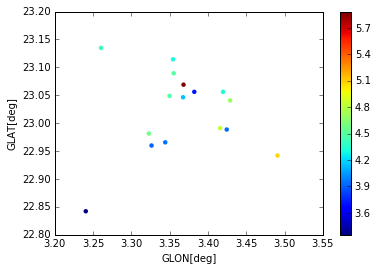

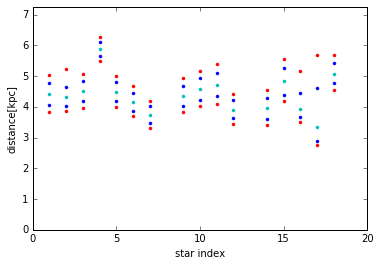

M13 has 119 members


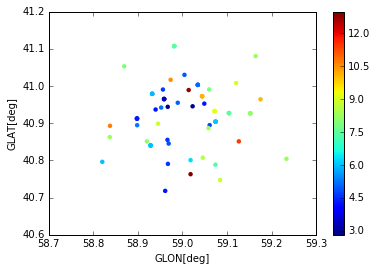

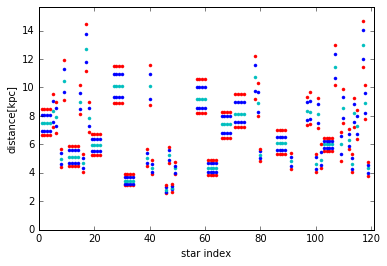

M15 has 20 members
M2 has 61 members


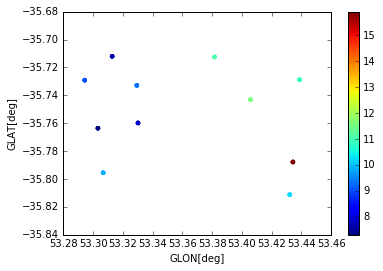

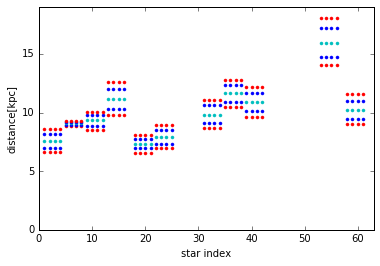

M3 has 226 members


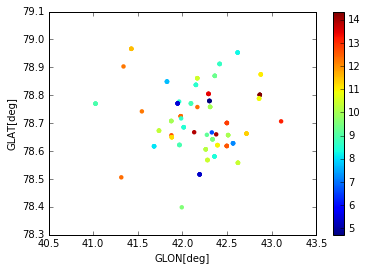

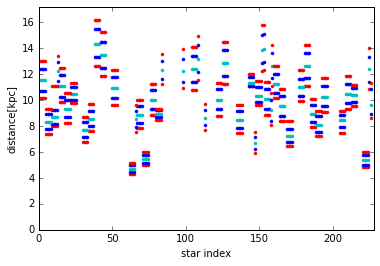

M5 has 142 members


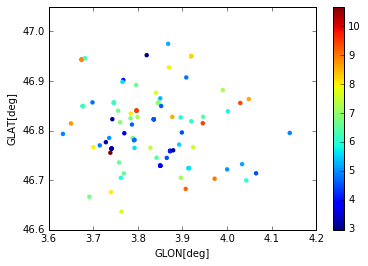

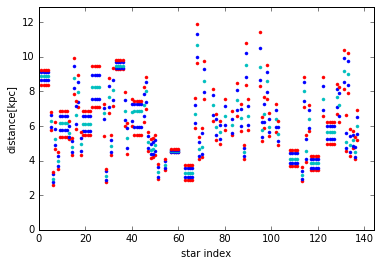

M53 has 25 members


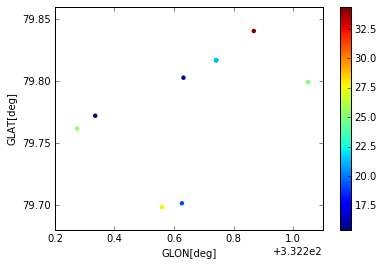

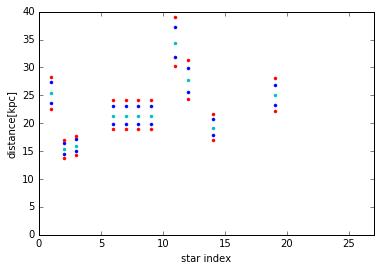

M67 has 24 members


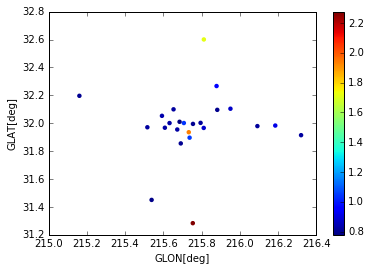

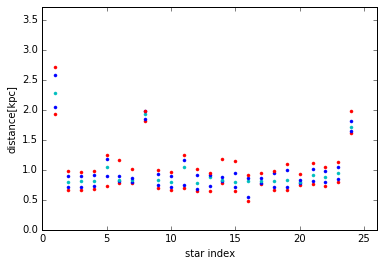

M71 has 28 members


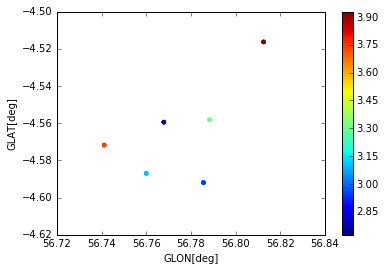

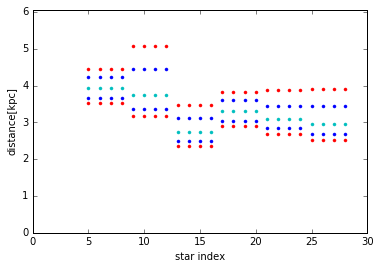

M92 has 54 members


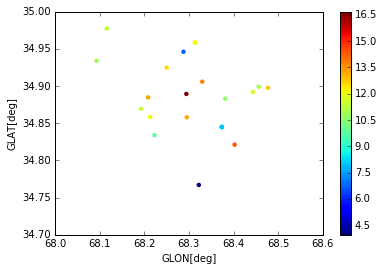

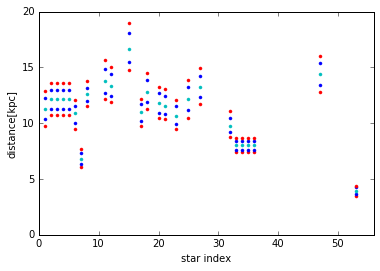

N5466 has 17 members
N6791 has 23 members


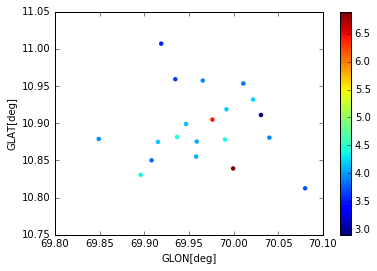

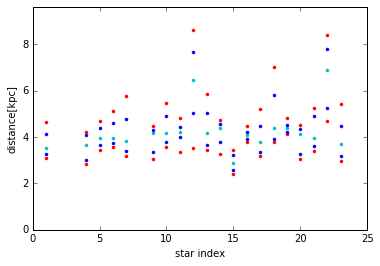

N6819 has 30 members


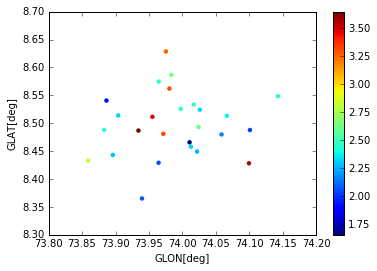

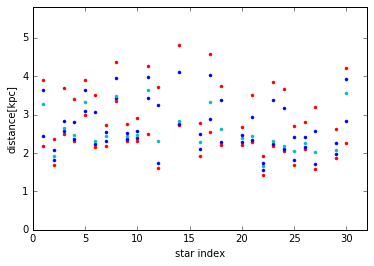

In [13]:
for group in member_table.groups:
    print '%s has %i members'%(group['cluster_name'][0], len(group))
    # plot locations of members
    valid = np.where(group['d_med'] > 0)[0]
    if len(valid) > 3:
        fig = plt.figure()
        plt.scatter(group['GLON'][valid], group['GLAT'][valid], c=group['d_med'][valid], lw=0)
        plt.xlabel('GLON[deg]')
        plt.ylabel('GLAT[deg]')
        plt.colorbar()
        plt.savefig('distance/l_b_d_%s.pdf'%group['cluster_name'][0])
        plt.show()
        # plot distance
        fig = plt.figure()
        x = np.arange(1, len(group)+1, 1)
        plt.plot(x, group['d_95L'], 'r.')
        plt.plot(x, group['d_68L'], 'b.')
        plt.plot(x, group['d_med'], 'c.')
        plt.plot(x, group['d_68U'], 'b.')
        plt.plot(x, group['d_95U'], 'r.')
        plt.ylim(0, np.amax(group['d_95U'])+1)
        plt.xlim(0, len(group)+2)
        plt.xlabel('star index')
        plt.ylabel('distance[kpc]')
        plt.savefig('distance/dist%s.pdf'%group['cluster_name'][0])
        plt.show()

In [ ]:
colors = ['b', 'r', 'c', 'y', 'm', 'g', 'pink', 'orange', 'gold', 'tan', 'lime', 'teal', 'purple']

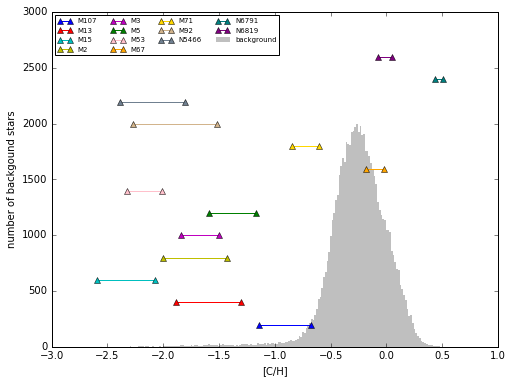

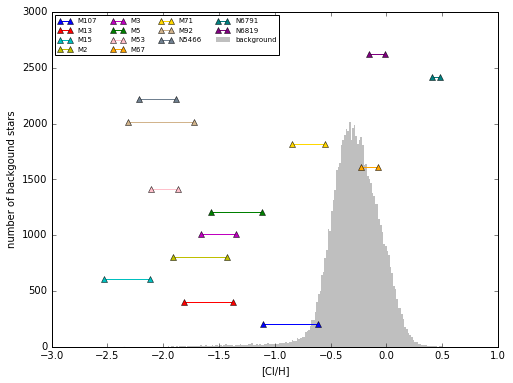

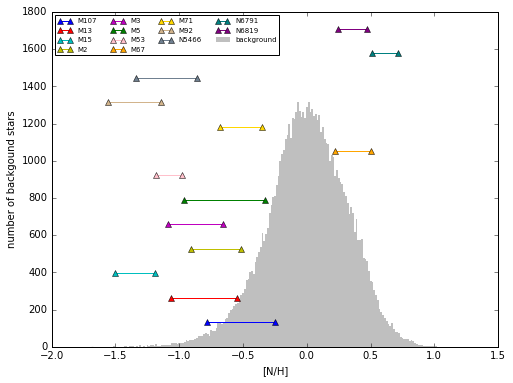

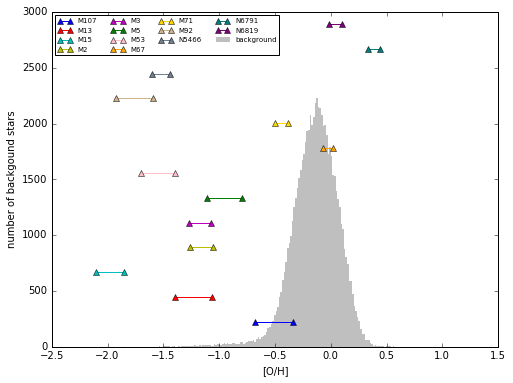

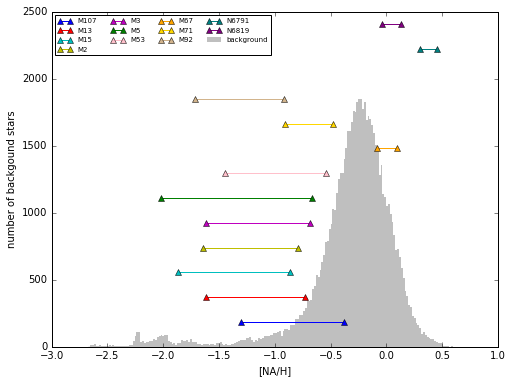

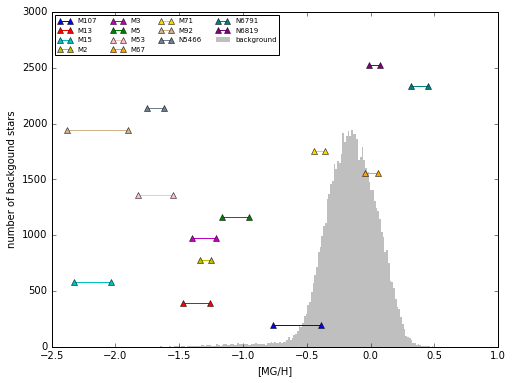

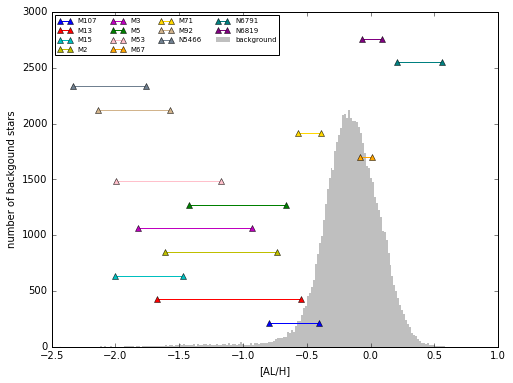

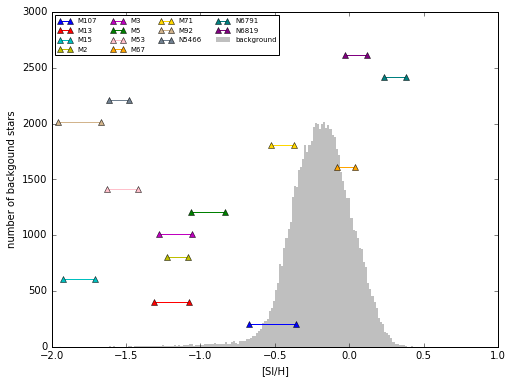

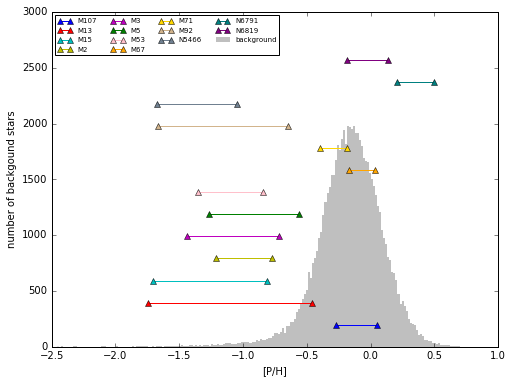

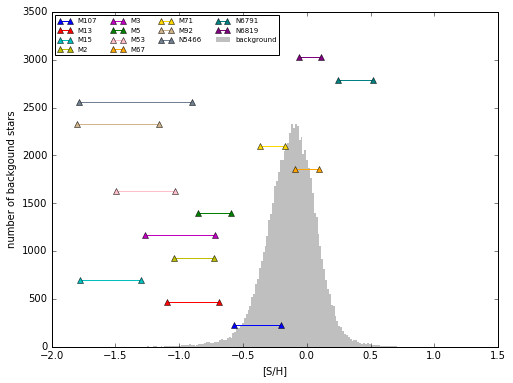

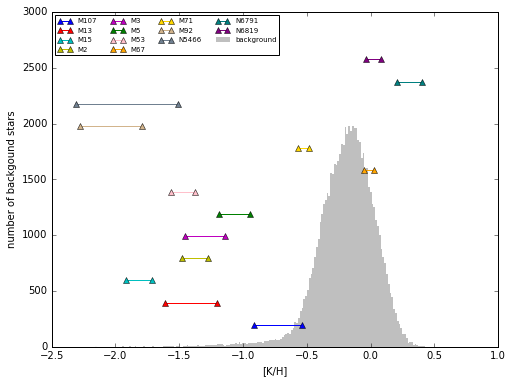

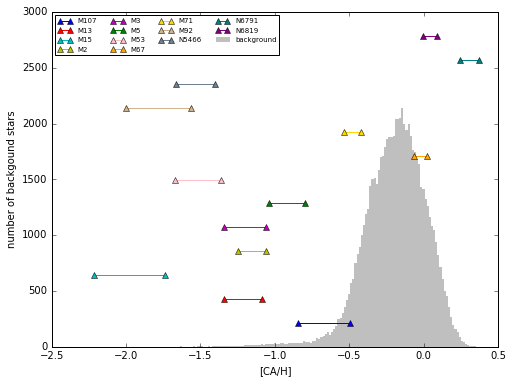

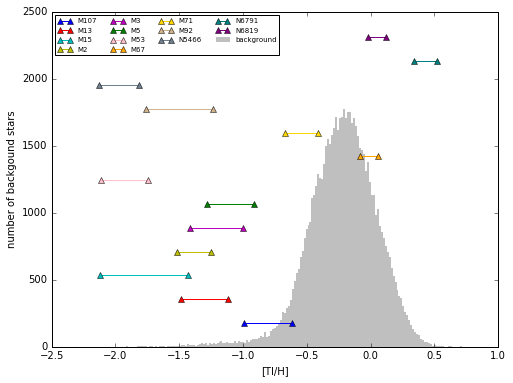

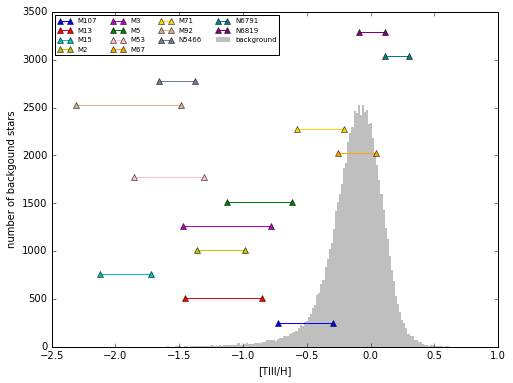

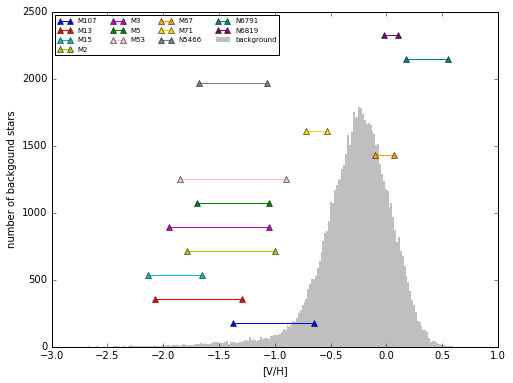

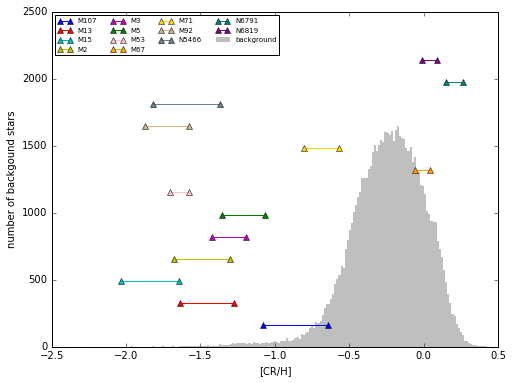

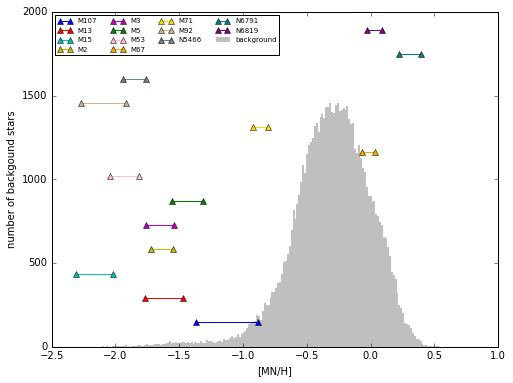

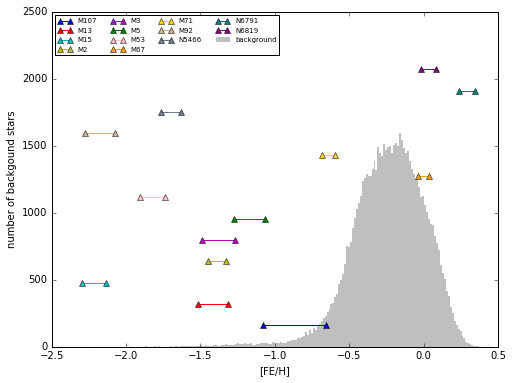

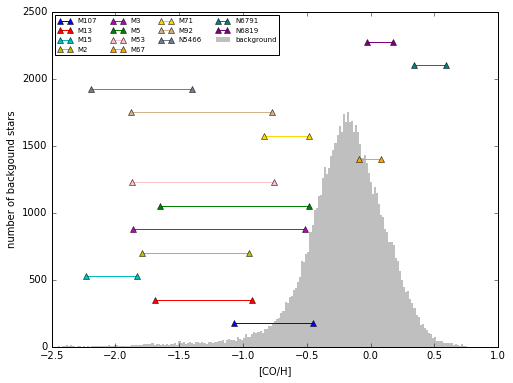

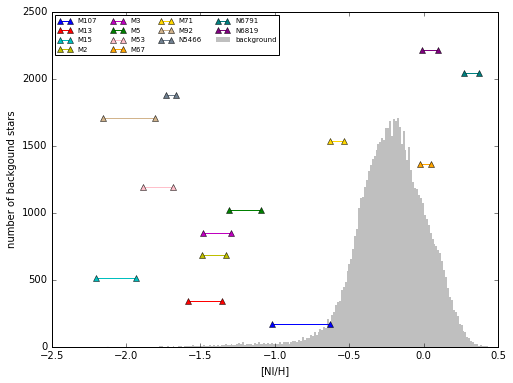

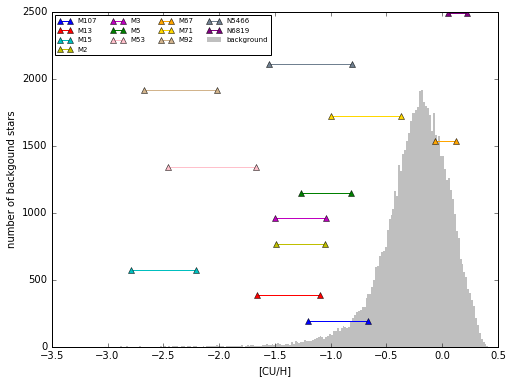

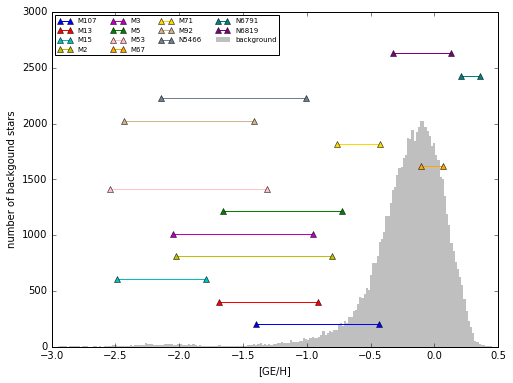

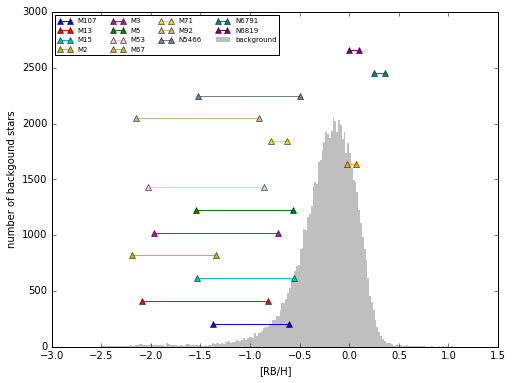

In [14]:
for n in range(len(element_names)):
    element = element_names[n]
    if element != 'FE_H':
        fig = plt.figure(figsize=(8,6))
        H, bins, patches = plt.hist(ap_table[index_chem][element] + ap_table[index_chem]['FE_H'], 
                                    bins=200, lw=0, color='grey', alpha=0.5, label='background')
        k = 0
        for group in member_table.groups:
            valid = np.where(group[element] > -999.)[0]
            if len(valid) > 5:
                mean = stats.tmean(group[valid][element] + group[valid]['FE_H'])
                std = stats.tstd(group[valid][element] + group[valid]['FE_H'])
                plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
                         label=group['cluster_name'][0])
            k += 1
        plt.ylabel('number of backgound stars')
        plt.xlabel(element_label_H[n])
        plt.legend(loc='upper left', fontsize = 'x-small', ncol=4)
#         plt.savefig('%s.jpg'%element, dpi=800)
        plt.show()
    else: 
        fig = plt.figure(figsize=(8,6))
        H, bins, patches = plt.hist(ap_table[index_chem][element], bins=200, lw=0, color='grey', alpha=0.5, label='background')
        k = 0
        for group in member_table.groups:
            valid = np.where(group[element] > -999.)[0]
            if len(valid) > 5:
                mean = stats.tmean(group[valid][element])
                std = stats.tstd(group[valid][element])
                plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
                         label=group['cluster_name'][0])
            k += 1
        plt.ylabel('number of backgound stars')
        plt.xlabel(element_label_H[n])
#         plt.savefig('%s.jpg'%element_label_H[n], dpi=800)
        plt.legend(loc='upper left', fontsize = 'x-small', ncol=4)
        plt.show()
            

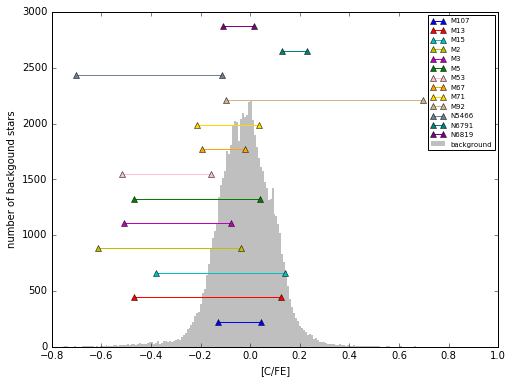

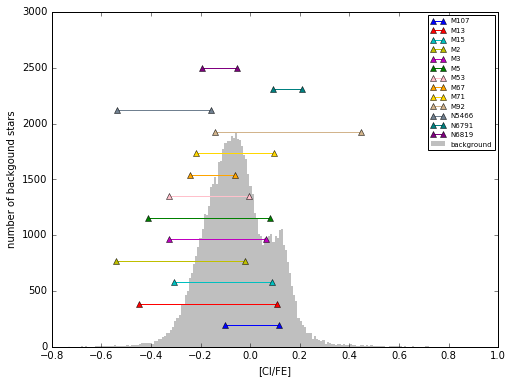

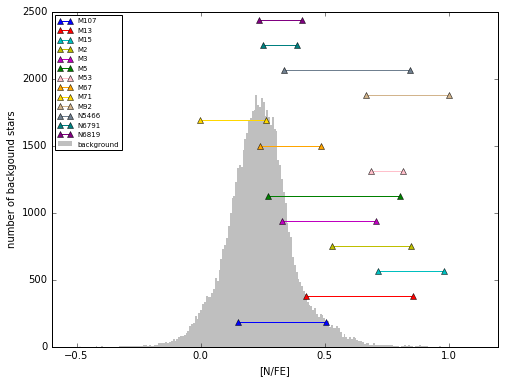

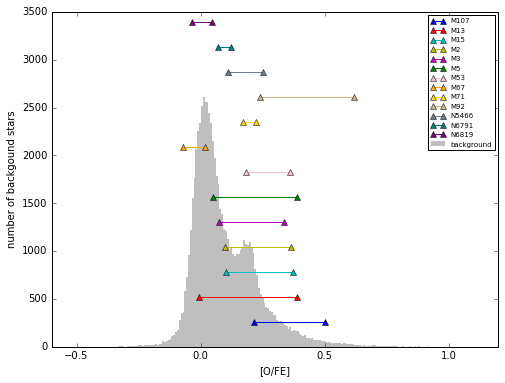

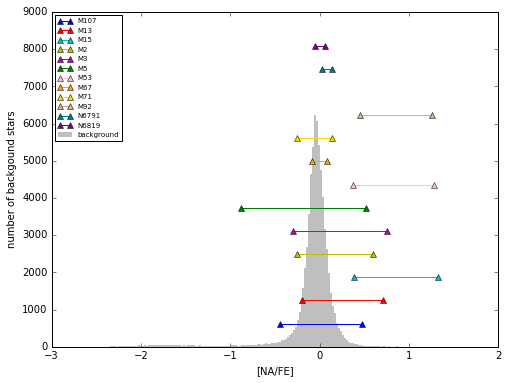

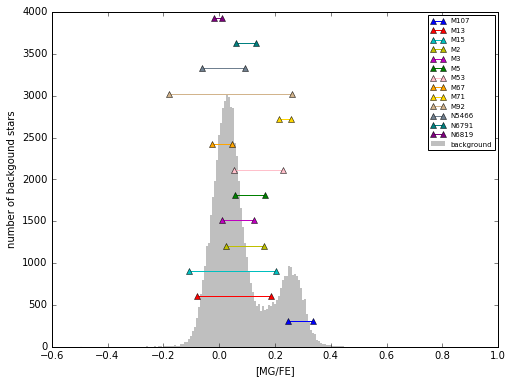

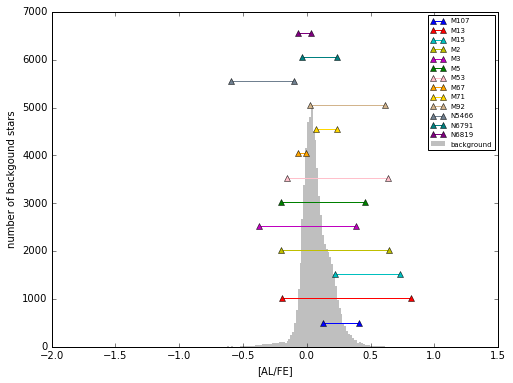

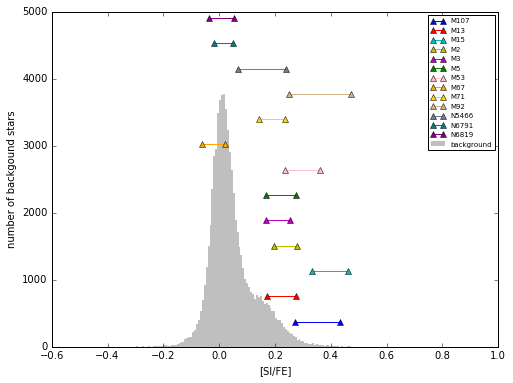

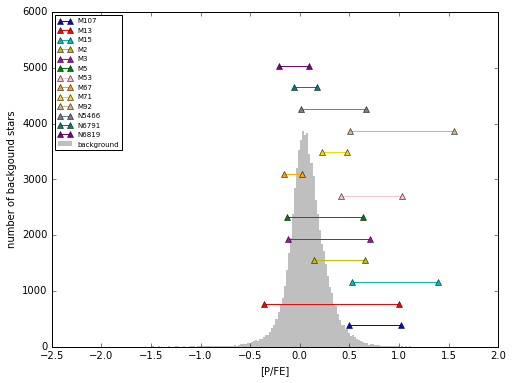

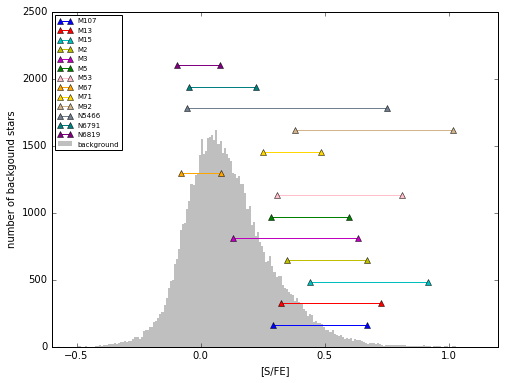

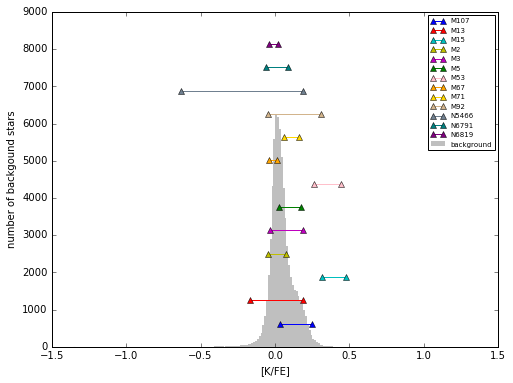

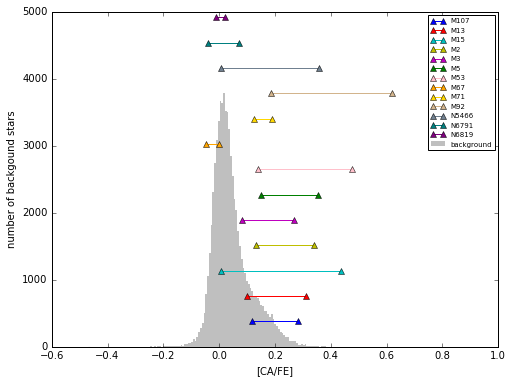

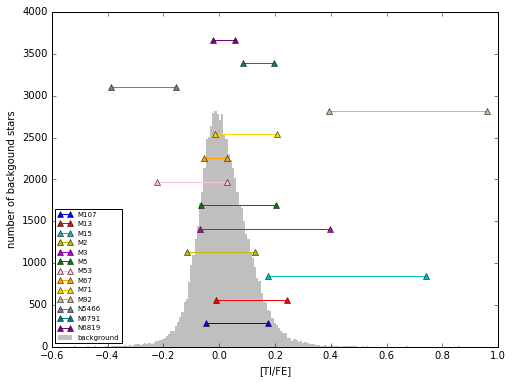

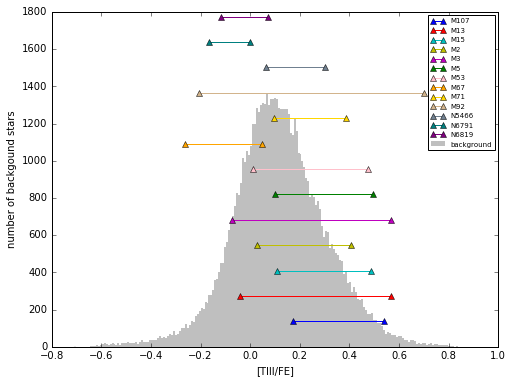

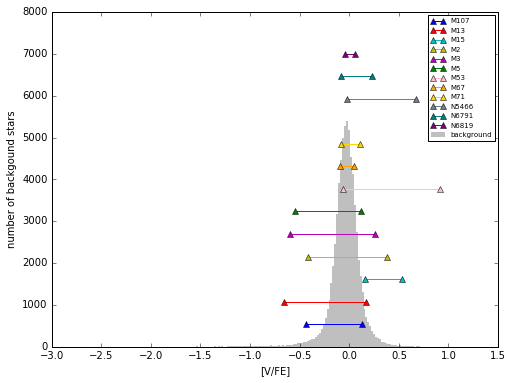

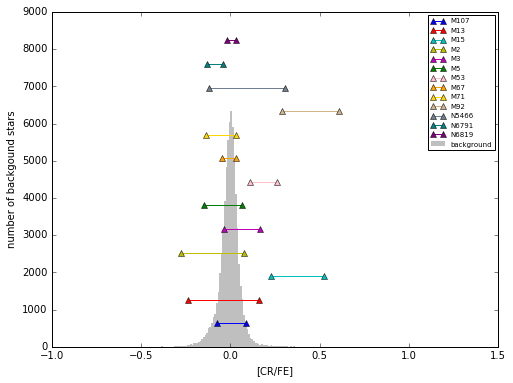

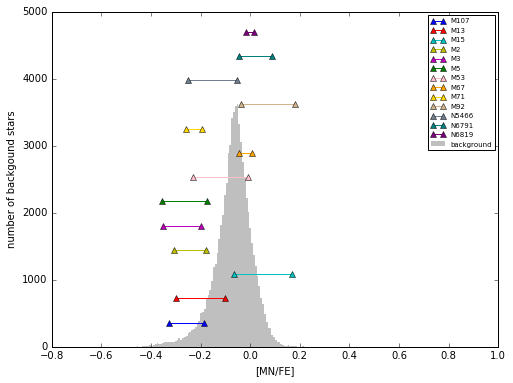

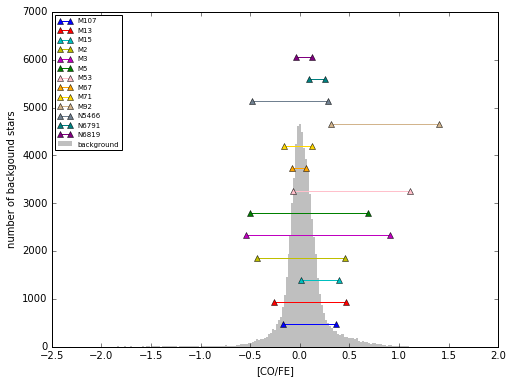

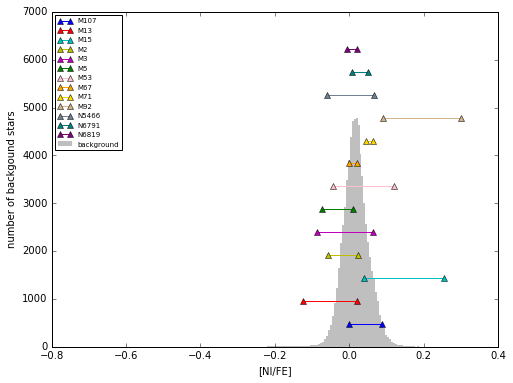

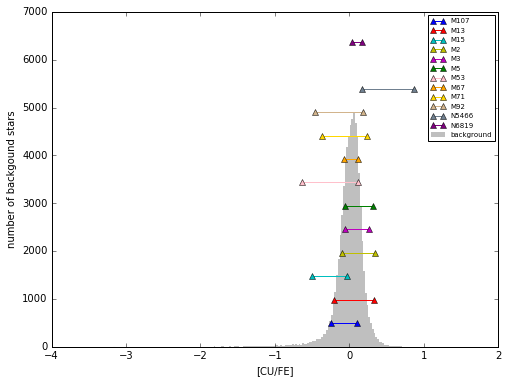

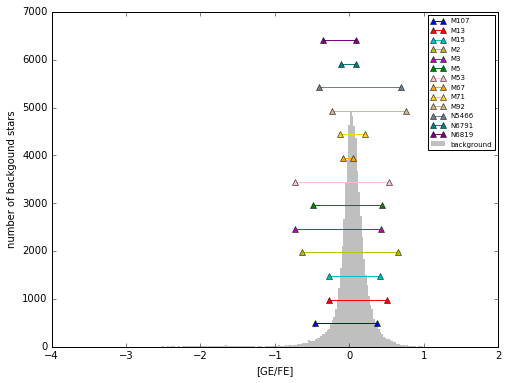

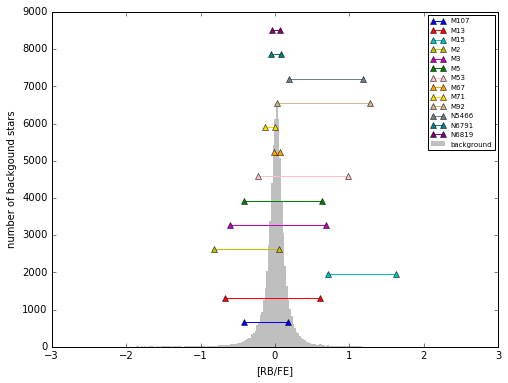

In [15]:

for n in range(len(element_names)):
    element = element_names[n]
    if element != 'FE_H':
        fig = plt.figure(figsize=(8,6))
        H, bins, patches = plt.hist(ap_table[index_chem][element], bins=200, lw=0, color='grey', alpha=0.5, label='background')
        k = 0
        for group in member_table.groups:
            valid = np.where(group[element] > -999.)[0]
            if len(valid) > 5:
                mean = stats.tmean(group[valid][element])
                std = stats.tstd(group[valid][element])
                plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
                         label=group['cluster_name'][0])
            k += 1
        plt.ylabel('number of backgound stars')
        plt.xlabel(element_label_Fe[n])
        plt.legend(loc=0, fontsize = 'x-small')
        plt.show()

/usr/users/bchen/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:803: RuntimeWarning: invalid value encountered in double_scalars
  return a.var() * n/(n-1.)


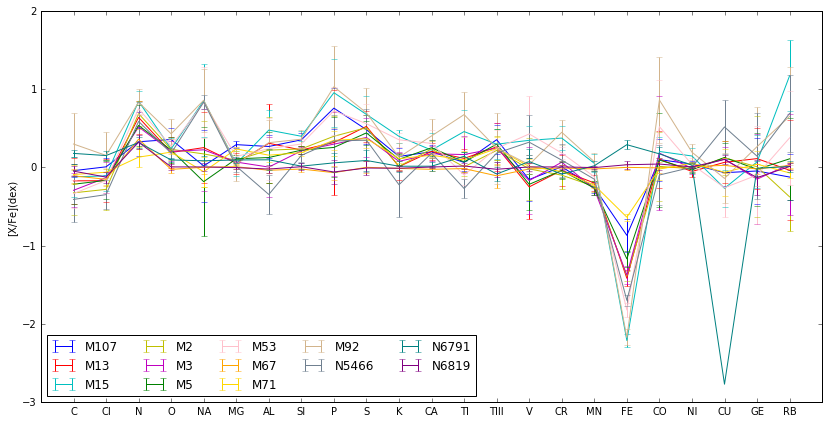

In [16]:

k = 0
fig = plt.figure(figsize=(14,7))
x = range(len(element_names))
for group in member_table.groups:
    chem = np.array([np.array(group[element], dtype=float) for element in element_names])
    chem_mean = np.zeros(len(element_names))
    chem_error = np.zeros(len(element_names))
    for n in range(len(element_names)):
        valid = np.where(chem[n] > -999.)[0]
        chem_mean[n] = stats.tmean(chem[n][valid])
        chem_error[n] = stats.tstd(chem[n][valid])
    plt.errorbar(x, chem_mean, yerr=chem_error, color=colors[k], label=group['cluster_name'][0])
    k += 1
element_label = [name.replace('_FE', '') for name in element_names]
element_label = [name.replace('_H', '') for name in element_label]
plt.xticks(np.arange(len(element_names)), element_label)
plt.xlim(-1, len(element_names))
plt.ylabel('[X/Fe](dex)')
plt.legend(loc=0, ncol=5)
plt.show()

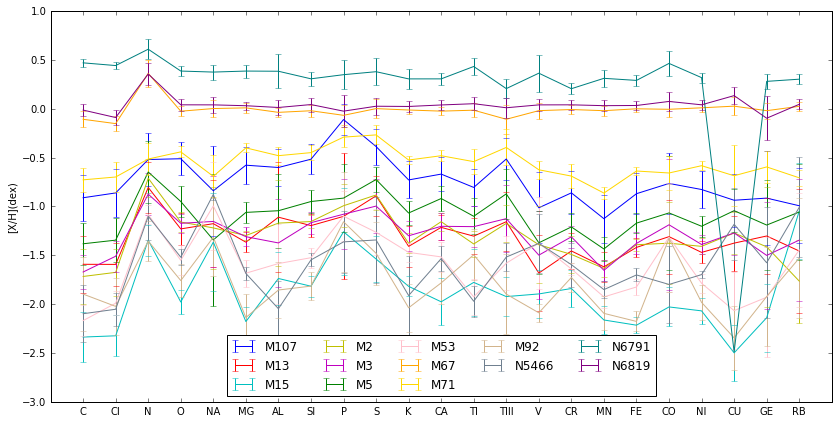

In [17]:

k = 0
fig = plt.figure(figsize=(14,7))
x = range(len(element_names))
for group in member_table.groups:
    idx_Fe = np.where(element_names == 'FE_H')[0][0]
    chem = [np.array(group[element] + group['FE_H'], dtype=float) for element in element_names]
    chem[idx_Fe] = np.array(group['FE_H'])
    chem = np.array(chem)
    chem_mean = np.zeros(len(element_names))
    chem_error = np.zeros(len(element_names))
    for n in range(len(element_names)):
        valid = np.where(chem[n] > -999.)[0]
        chem_mean[n] = stats.tmean(chem[n][valid])
        chem_error[n] = stats.tstd(chem[n][valid])
    plt.errorbar(x, chem_mean, yerr=chem_error, color=colors[k], label=group['cluster_name'][0])
    k += 1
element_label = [name.replace('_FE', '') for name in element_names]
element_label = [name.replace('_H', '') for name in element_label]
plt.xticks(np.arange(len(element_names)), element_label)
plt.xlim(-1, len(element_names))
plt.ylabel('[X/H](dex)')
plt.legend(loc=0, ncol=5)
plt.show()

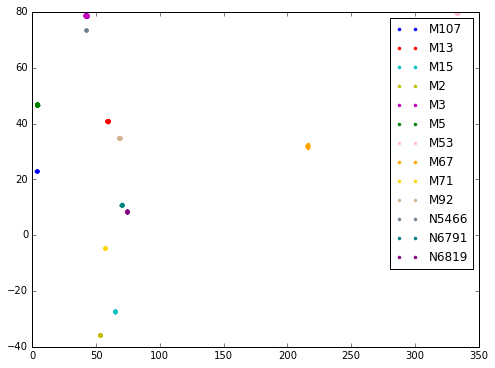

In [18]:
fig = plt.figure(figsize=(8,6))
k = 0
for group in member_table.groups:
    plt.plot(group['GLON'], group['GLAT'], '.', color=colors[k], label=group['cluster_name'][0])
    k += 1
plt.legend(loc=0)
plt.show()

In [19]:
# num_std = 2.
# nums_member = []
# nums_similar = []
# nums_overlap = []
# similar_table_names = ['cluster_name', 'members', 'chemically similar stars', 
#                        'chemically similar members']
# # iterate through each cluster
# for group in member_table.groups:
#     # get chemical abundance of the cluster
#     chem = np.array([np.array(group[element], dtype=float) for element in element_names])
#     chem = chem.T
#     # store mean and error for each element
#     chem_mean = np.zeros(len(chem[0]))
#     chem_error = np.zeros(len(chem[0])) + 999.
#     # iterate through each element
#     for n in range(len(chem[0])):
#         valid = np.where(chem[:,n] > -999.)[0]
#         if len(valid) > 5: 
#             # get mean and error of the element
#             chem_mean[n] = np.mean(chem[:,n][valid])
#             chem_error[n] = np.std(chem[:,n][valid])
#     print group['cluster_name'][0]
#     print Table([element_names, chem_error], 
#                       names=['element', 'spread'], meta={'name': 'error table'})
#     # a list of indexes for all stars with 15 elements
#     similar = np.arange(len(ap_table))
#     # iterate through each element
#     for m in range(len(element_names)):
#         # get chemically similar stars with 10 elements
#         select = np.where(np.abs(ap_table[element_names[m]] - chem_mean[m]) < chem_error[m] * num_std)[0]
#         similar = np.intersect1d(similar, select)
#     # get overlap between chemically similar stars and members
#     overlap = np.intersect1d(group['APOGEE_ID'], ap_table[similar]['APOGEE_ID'])
#     # store the numbers 
#     nums_member.append(len(group))
#     nums_similar.append(len(similar))
#     nums_overlap.append(len(overlap))
# #     print group['cluster_name'][0], len(group), len(similar), len(overlap)
#     k += 1
# # get cluster names
# names = [member_table.groups.keys[n][0] for n in range(len(member_table.groups.keys))]
# # convert to numpy array and set data type
# nums_member = np.array(nums_member, dtype=int)
# nums_similar = np.array(nums_similar, dtype=int)
# nums_overlap = np.array(nums_overlap, dtype=int)
# # create a table
# similar_table = Table([names, nums_member, nums_similar, nums_overlap], 
#                       names=similar_table_names, meta={'name': 'percentage table'})
# # print table
# print similar_table

In [20]:
# similar_table_names = ['cluster_name', 'members', 'similar stars', 'similar members']
# for n in range(1, 11, 1):
#     pct = n/10.
#     print pct
#     nums_member = []
#     nums_similar = []
#     nums_overlap = []
#     # iterate through each cluster
#     for group in member_table.groups:
#         # get chemical abundance of the cluster
#         chem = np.array([np.array(group[element], dtype=float) for element in element_names])
#         chem = chem.T
#         # store mean and error for each element
#         chem_max = np.amax(chem, axis=0)
#         chem_min = np.amin(chem, axis=0)
#         similar = np.arange(len(ap_table))
#         # iterate through each element
#         for m in range(len(element_names)):
#             select = np.where((ap_table[element_names[m]] <= chem_max[m]*pct) & 
#                               (ap_table[element_names[m]] >= chem_min[m]*pct))[0]
#             similar = np.intersect1d(similar, select)
#         # get overlap between chemically similar stars and members
#         overlap = np.intersect1d(group['APOGEE_ID'], ap_table[similar]['APOGEE_ID'])
#         # store the numbers 
#         nums_member.append(len(group))
#         nums_similar.append(len(similar))
#         nums_overlap.append(len(overlap))
#     #     print group['cluster_name'][0], len(group), len(similar), len(overlap)
#         k += 1
#     # get cluster names
#     names = [member_table.groups.keys[n][0] for n in range(len(member_table.groups.keys))]
#     # convert to numpy array and set data type
#     nums_member = np.array(nums_member, dtype=int)
#     nums_similar = np.array(nums_similar, dtype=int)
#     nums_overlap = np.array(nums_overlap, dtype=int)
#     # create a table
#     similar_table = Table([names, nums_member, nums_similar, nums_overlap], 
#                           names=similar_table_names, meta={'name': 'percentage table'})
#     # print table
#     print similar_table

In [21]:
similar_table_names = ['cluster_name', 'members', 'similar stars', 'similar members']
pct = 1.
nums_member = []
nums_similar = []
nums_overlap = []
# iterate through each cluster
for group in member_table.groups:
    # get chemical abundance of the cluster
    chem = np.array([np.array(group[element], dtype=float) for element in element_names])
    chem = chem.T
#     chem = imp.fit_transform(chem)
    # store mean and error for each element
    chem_max = np.amax(chem, axis=0)
    chem_min = np.amin(chem, axis=0)
#     print group['cluster_name'][0]
#     print chem_max
#     print chem_min
    v_max = np.amax(group['VHELIO_AVG'])
    v_min = np.amin(group['VHELIO_AVG'])
    # a list of indexes for all stars with 15 elements
    similar = np.arange(len(ap_table))
    # iterate through each element
    for m in range(len(element_names)):
        # get chemically similar stars with 10 elements
        select = np.where((ap_table[element_names[m]] <= chem_max[m]*pct) & 
                          (ap_table[element_names[m]] >= chem_min[m]*pct))[0]
        similar = np.intersect1d(similar, select)
#     # select stars that have similar radial velocity
#     select = np.where((ap_table['VHELIO_AVG'] <= v_max) & 
#                           (ap_table['VHELIO_AVG'] >= v_min))[0]
#     similar = np.intersect1d(similar, select)
    # get overlap between chemically similar stars and members
    overlap = np.intersect1d(group['APOGEE_ID'], ap_table[similar]['APOGEE_ID'])
    # store the numbers 
    nums_member.append(len(group))
    nums_similar.append(len(similar))
    nums_overlap.append(len(overlap))
#     print group['cluster_name'][0], len(group), len(similar), len(overlap)
    k += 1
# get cluster names
names = [member_table.groups.keys[n][0] for n in range(len(member_table.groups.keys))]
# convert to numpy array and set data type
nums_member = np.array(nums_member, dtype=int)
nums_similar = np.array(nums_similar, dtype=int)
nums_overlap = np.array(nums_overlap, dtype=int)
# create a table
similar_table = Table([names, nums_member, nums_similar, nums_overlap], 
                      names=similar_table_names, meta={'name': 'percentage table'})
# print table
print similar_table

cluster_name members similar stars similar members
------------ ------- ------------- ---------------
        M107      18         54267              18
         M13     119         48356              71
         M15      20         47354              11
          M2      61         47545              19
          M3     226         48110              73
          M5     142         48638             103
         M53      25         47359              16
         M67      24          1326              24
         M71      28         47511               7
         M92      54         47618              48
       N5466      17         47353               8
       N6791      23         54671              23
       N6819      30         57350              30


In [22]:
# # Run KMeans
# from sklearn.cluster import KMeans
# from sklearn import preprocessing
# from sklearn.metrics.cluster import v_measure_score
# import cPickle as pickle

# chem = np.array([np.array(ap_table[index_chem][element], dtype=float) for element in element_names])
# chem = chem.T
# chem_scaled = preprocessing.scale(chem)
# kmeans = KMeans(n_clusters=256)
# kmeans.fit(chem)
# labels = kmeans.labels_
# pickle.dump(labels, open( "DR_13_KMeans.p", "wb" ) )


In [23]:
# for n in range(256):
#     index_km_gp = index_chem[np.where(labels == n)[0]]
#     index_km_mem = np.intersect1d(index_km_gp, index_member)
#     index_km_bg = list(set(index_km_gp) - set(index_km_mem))
#     km_bg_table = ap_table[index_km_bg]
#     km_mem_table = ap_table[index_km_mem]
    
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(km_bg_table['GLON'], km_bg_table['GLAT'], 'r.', label='backgroup')
#     plt.plot(km_mem_table['GLON'], km_mem_table['GLAT'], 'b.', label='member')
#     plt.xlabel('GLON')
#     plt.ylabel('GLAT')
#     plt.title('%i-th KMeans group'%n)
#     plt.legend(loc=0)
#     plt.show()
    
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(km_bg_table['GLON'], km_bg_table['VHELIO_AVG'], 'r.', label='backgroup')
#     plt.plot(km_mem_table['GLON'], km_mem_table['VHELIO_AVG'], 'b.', label='member')
#     plt.xlabel('GLON')
#     plt.ylabel('VHELIO_AVG')
#     plt.title('%i-th KMeans group'%n)
#     plt.legend(loc=0)
#     plt.show()
    
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(km_bg_table['GLON'], km_bg_table['d_med'], 'r.', label='backgroup')
#     plt.plot(km_mem_table['GLON'], km_mem_table['d_med'], 'b.', label='member')
#     plt.xlabel('GLON')
#     plt.ylabel('d_med')
#     plt.ylim(-5, 50)
#     plt.title('%i-th KMeans group'%n)
#     plt.legend(loc=0)
#     plt.show()

In [24]:
# chem = [np.array(ap_table[index_chem][element] + ap_table[index_chem]['FE_H'], dtype=float) for element in element_names]
# chem[idx_Fe] = np.array(ap_table[index_chem]['FE_H'])
# chem = np.array(chem)
# chem = chem.T
# chem_scaled = preprocessing.scale(chem)
# kmeans = KMeans(n_clusters=256)
# kmeans.fit(chem)
# labels_H = kmeans.labels_
# pickle.dump(labels, open( "DR_13_KMeans_H.p", "wb" ))

In [25]:
# for n in range(256):
#     index_km_gp = index_chem[np.where(labels_H == n)[0]]
#     index_km_mem = np.intersect1d(index_km_gp, index_member)
#     index_km_bg = list(set(index_km_gp) - set(index_km_mem))
#     km_bg_table = ap_table[index_km_bg]
#     km_mem_table = ap_table[index_km_mem]
    
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(km_bg_table['GLON'], km_bg_table['GLAT'], 'r.', label='backgroup')
#     plt.plot(km_mem_table['GLON'], km_mem_table['GLAT'], 'b.', label='member')
#     plt.xlabel('GLON')
#     plt.ylabel('GLAT')
#     plt.title('%i-th KMeans group'%n)
#     plt.legend(loc=0)
#     plt.show()
    
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(km_bg_table['GLON'], km_bg_table['VHELIO_AVG'], 'r.', label='backgroup')
#     plt.plot(km_mem_table['GLON'], km_mem_table['VHELIO_AVG'], 'b.', label='member')
#     plt.xlabel('GLON')
#     plt.ylabel('VHELIO_AVG')
#     plt.title('%i-th KMeans group'%n)
#     plt.legend(loc=0)
#     plt.show()
    
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(km_bg_table['GLON'], km_bg_table['d_med'], 'r.', label='backgroup')
#     plt.plot(km_mem_table['GLON'], km_mem_table['d_med'], 'b.', label='member')
#     plt.xlabel('GLON')
#     plt.ylabel('d_med')
#     plt.ylim(-5, 50)
#     plt.title('%i-th KMeans group'%n)
#     plt.legend(loc=0)
#     plt.show()

In [26]:
# fig = plt.figure()
# valid = np.where((ap_table['d_med'] > 0.)*(ap_table['d_med'] < 15.))[0]
# plt.hist2d(ap_table['GLON'][valid], ap_table['d_med'][valid], bins=200)
# plt.colorbar()
# plt.xlabel('GLON')
# plt.ylabel('d_med')
# plt.ylim(0, 15)
# plt.show()

# fig = plt.figure()
# valid = np.where(np.abs(ap_table['VHELIO_AVG'] < 300.))[0]
# plt.hist2d(ap_table['GLON'][valid], ap_table['VHELIO_AVG'][valid], bins=200)
# plt.colorbar()
# plt.xlabel('GLON')
# plt.ylabel('VHELIO_AVG')
# plt.ylim(-300, 200)
# plt.show()